In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier

plt.style.use("ggplot")
warnings.filterwarnings("ignore")
seed = 27

# Loading and Visualizing the Dataset

In [2]:
dataset = pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
dataset = dataset.drop(["Unnamed: 32"], axis=1)

# Used for visualization
dataset_copy = dataset.copy()
dataset_copy["diagnosis"] = dataset_copy["diagnosis"].map({"M": "Maligant", "B": "Benign"})

dataset["diagnosis"] = dataset["diagnosis"].map({"M": 1, "B": 0})
X = dataset.drop("diagnosis", axis=1)
y = dataset["diagnosis"]

## Distibution of Numerical Features by Diagnosis

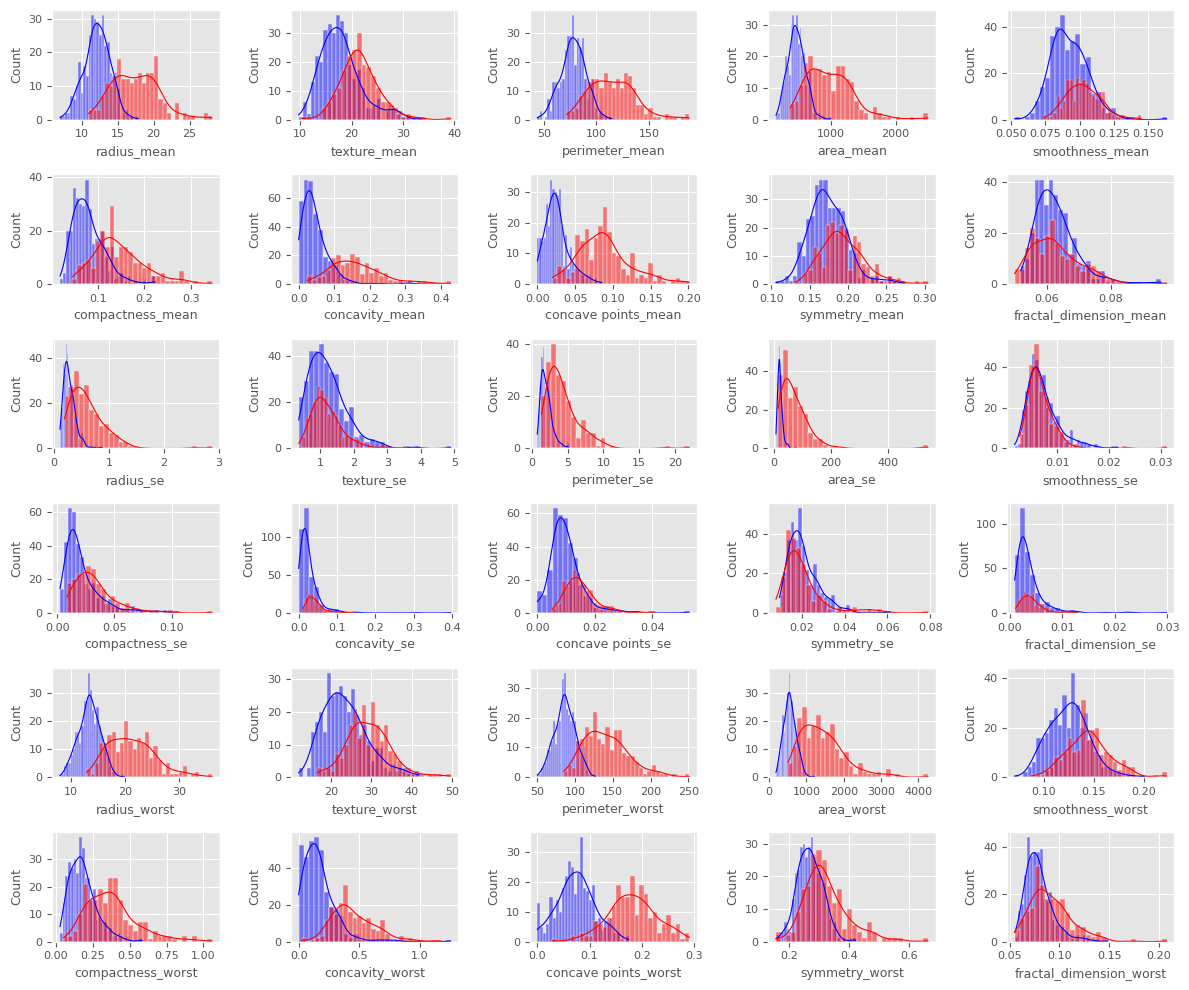

In [3]:
features = dataset_copy.columns[2:]
plt.figure(figsize=(12, 10))

benign_samples = dataset_copy[dataset_copy["diagnosis"] == "Benign"]
maligant_samples = dataset_copy[dataset_copy["diagnosis"] == "Maligant"]

for i, feature in enumerate(features):
    plt.subplot(6, 5, i + 1)
    sns.histplot(benign_samples[feature], kde=True, color="blue", bins=30, line_kws={"linewidth": 0.8})
    sns.histplot(maligant_samples[feature], kde=True, color="red", bins=30, line_kws={"linewidth": 0.8})
    plt.tick_params(axis="both", which="major", labelsize=8)
    plt.xlabel(feature, fontsize=9)
    plt.ylabel("Count", fontsize=9)
    
plt.tight_layout()
plt.show()

## Label Distribution

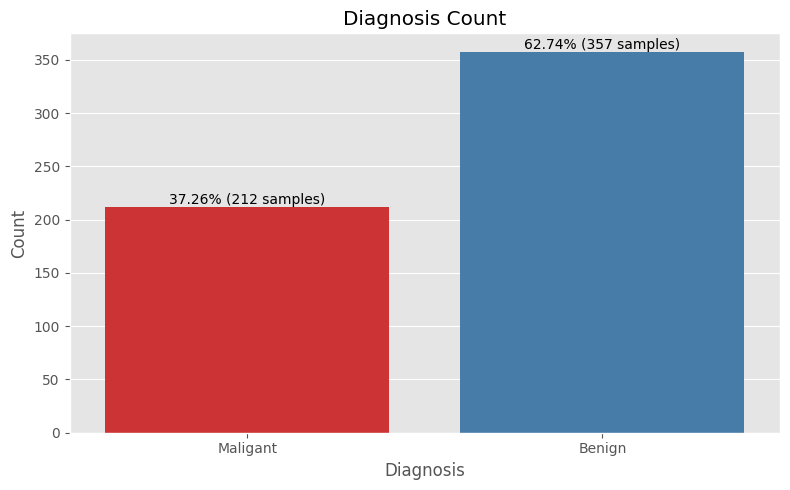

In [4]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="diagnosis", data=dataset_copy, palette="Set1")
plt.title("Diagnosis Count")
plt.xlabel("Diagnosis")
plt.ylabel("Count")

total = len(dataset_copy)
maligant = len(dataset_copy[dataset_copy["diagnosis"] == "Maligant"])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            "{:1.2f}% ({} samples)".format(100 * height / total, int(height)),
            ha="center") 

plt.tight_layout()
plt.show()

## Feature Correlations

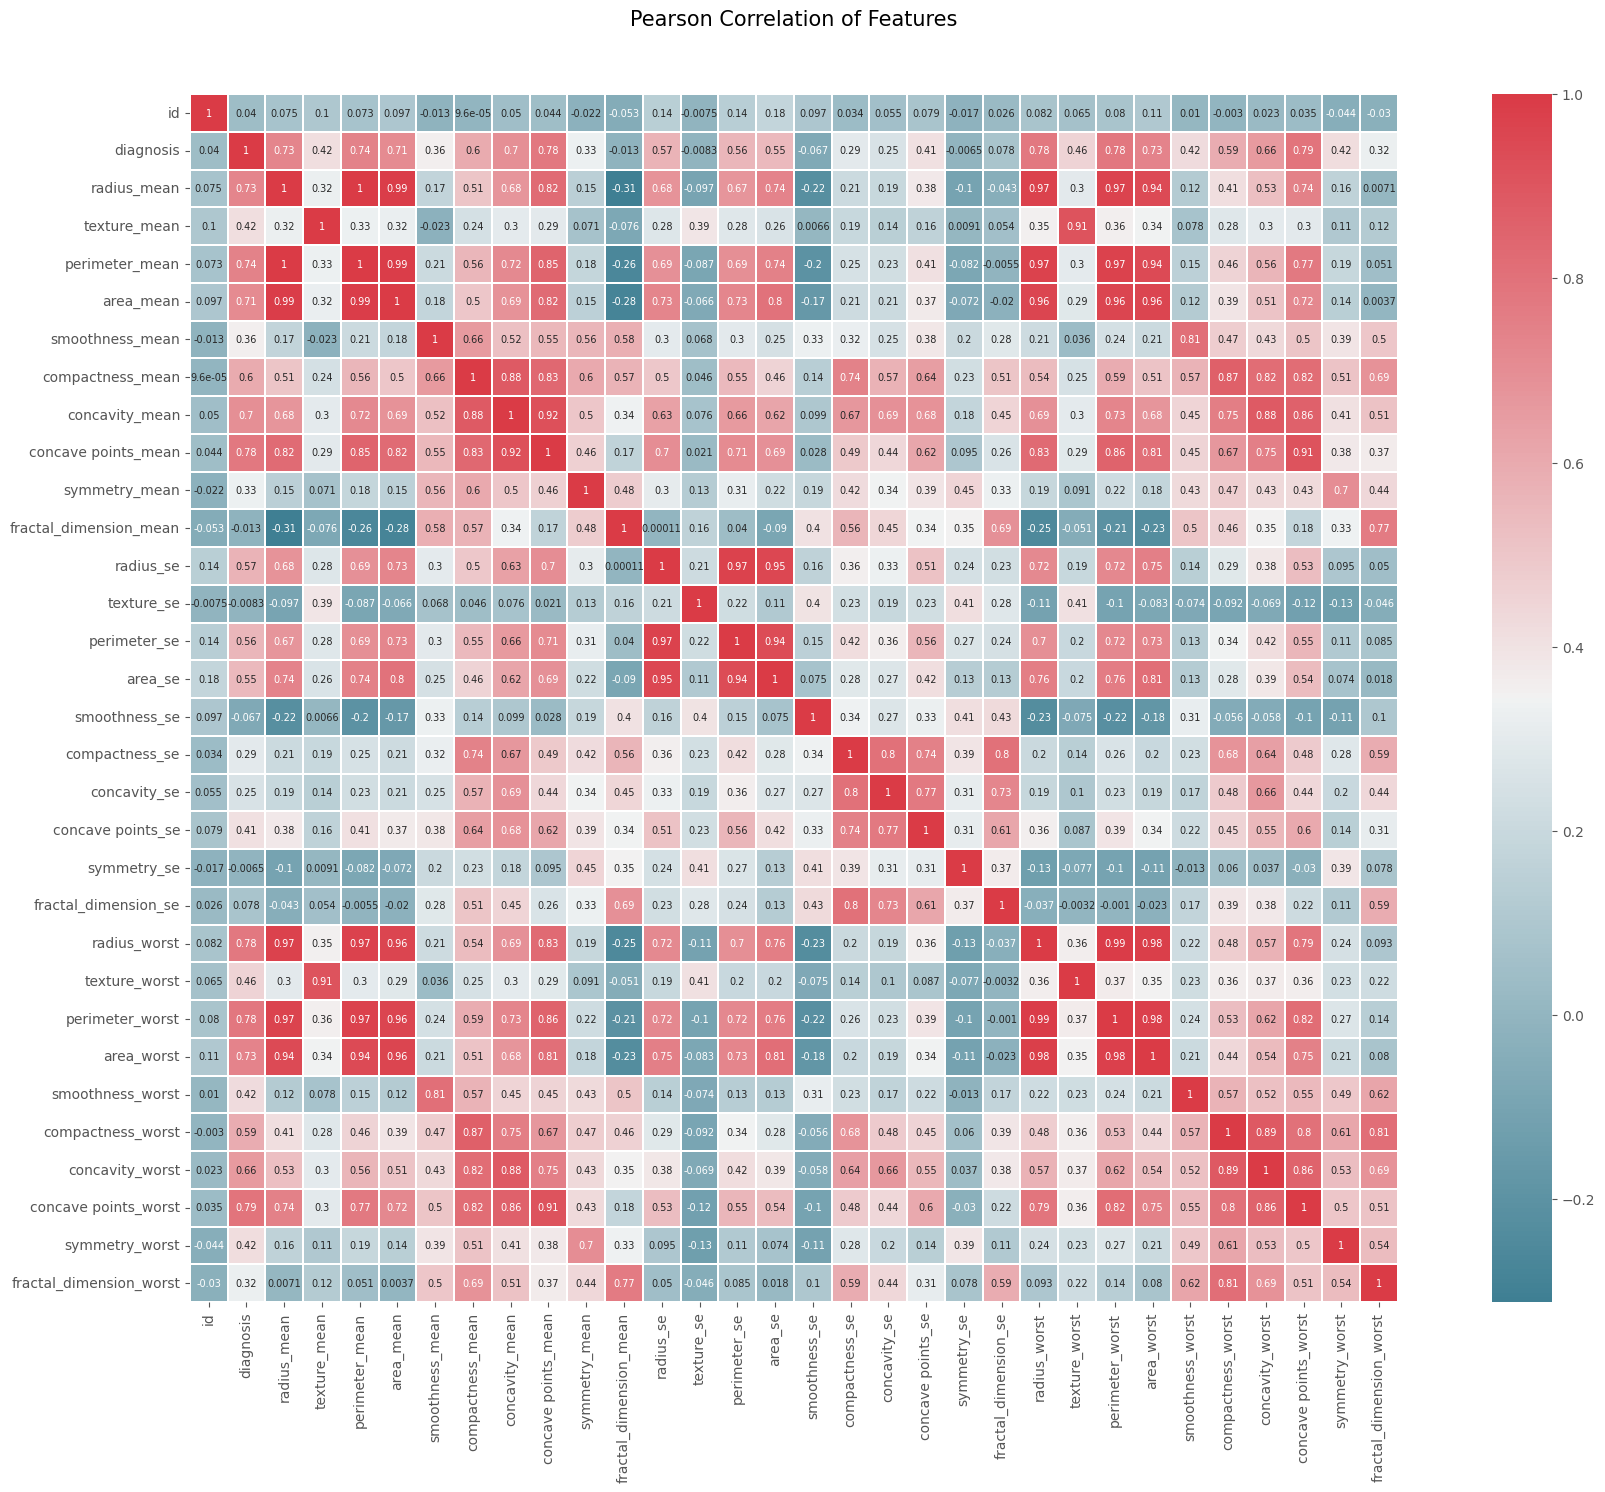

In [5]:
_, ax = plt.subplots(figsize=(20, 15))
colormap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(
    dataset.corr(),
    cmap=colormap,
    square=True,
    cbar_kws={"shrink": 1},
    ax=ax,
    annot=True,
    linewidths=0.1, 
    vmax=1.0, 
    linecolor="white",
    annot_kws={"fontsize": 7}
)

plt.title("Pearson Correlation of Features", y=1.05, size=15)
plt.tight_layout()
plt.show()

# Training a Base Model

In [6]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [7]:
base_lgbm = LGBMClassifier(verbose=-100, random_state=seed)
base_lgbm = base_lgbm.fit(X, y)

scores = cross_val_score(base_lgbm, X, y, cv=k_fold, scoring="roc_auc")
print("AUC: %.2f%% (%.2f%%)" % (scores.mean() * 100, scores.std() * 100))

AUC: 99.31% (0.79%)


# Tuning Base Model

In [8]:
lgbm_model = LGBMClassifier(verbose=-100, random_state=seed)

lgbm_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "max_depth": [3, 4, 5],
    "min_child_samples": [3, 4, 5, 6, 7],
    "num_leaves": [5, 10, 20]
}
lgbm_gs = GridSearchCV(
    lgbm_model,
    param_grid=lgbm_param_grid,
    cv=k_fold,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)
lgbm_gs.fit(X, y)

print(f"\nBest Score: {lgbm_gs.best_score_}")
print(f"Best Params: {lgbm_gs.best_params_}")

Fitting 5 folds for each of 675 candidates, totalling 3375 fits

Best Score: 0.9966870343508077
Best Params: {'learning_rate': 0.2, 'max_depth': 4, 'min_child_samples': 7, 'n_estimators': 100, 'num_leaves': 5}


In [9]:
tuned_lgbm = LGBMClassifier(verbose=-100, random_state=seed, **lgbm_gs.best_params_)
tuned_lgbm = tuned_lgbm.fit(X, y)

results = cross_val_score(tuned_lgbm, X, y, cv=k_fold, scoring="roc_auc")
print("AUC: %.2f%% (%.2f%%)" % (results.mean() * 100, results.std() * 100))

AUC: 99.67% (0.26%)


## Feature Importances of the Tuned Model

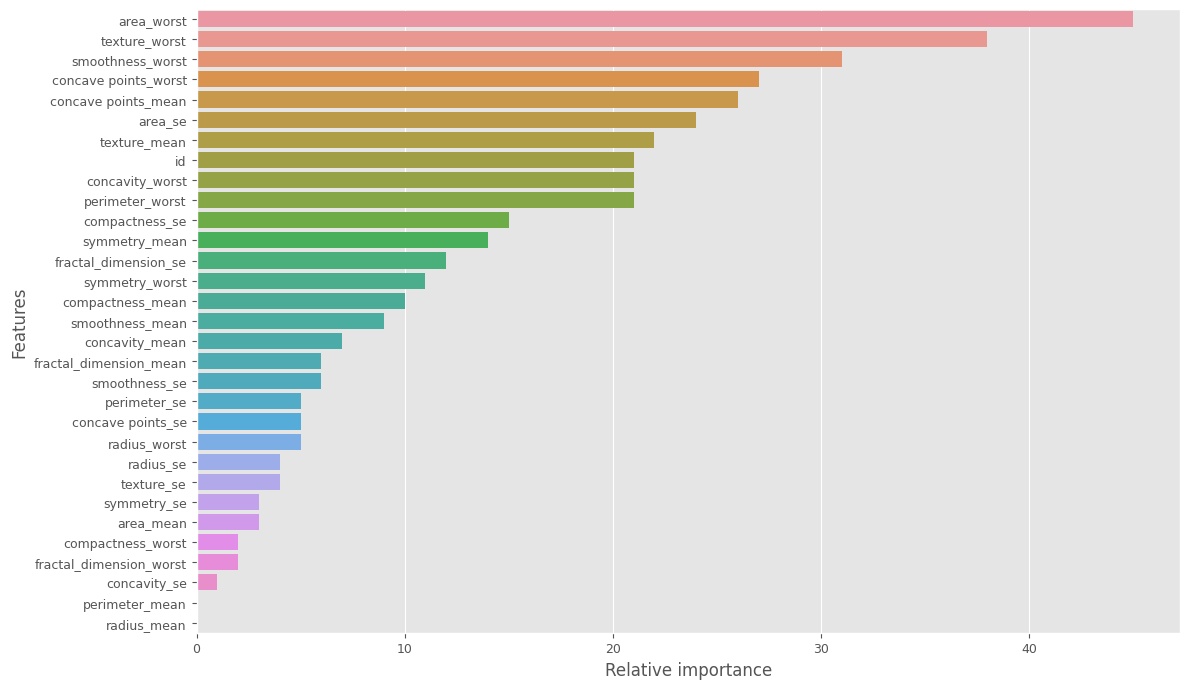

In [10]:
plt.figure(figsize=(12, 7))
indices = np.argsort(tuned_lgbm.feature_importances_)[::-1]
ax = sns.barplot(y=X.columns[indices], x=tuned_lgbm.feature_importances_[indices], orient="h")
ax.set_xlabel("Relative importance", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

# Feature Selection wtih RFECV

In [11]:
lgbm = LGBMClassifier(verbose=-100, random_state=seed, **lgbm_gs.best_params_)
rfecv = RFECV(estimator=lgbm, step=1, cv=5, scoring="roc_auc")
rfecv = rfecv.fit(X, y)

scores = cross_val_score(lgbm, X[X.columns[rfecv.support_]], y, cv=5)
print("AUC: %.2f%% (%.2f%%)\n" % (scores.mean() * 100, scores.std() * 100))

print("Optimal number of features: ", rfecv.n_features_)
print("Selected features: ", X.columns[rfecv.support_])

AUC: 97.19% (1.51%)

Optimal number of features:  28
Selected features:  Index(['id', 'texture_mean', 'area_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


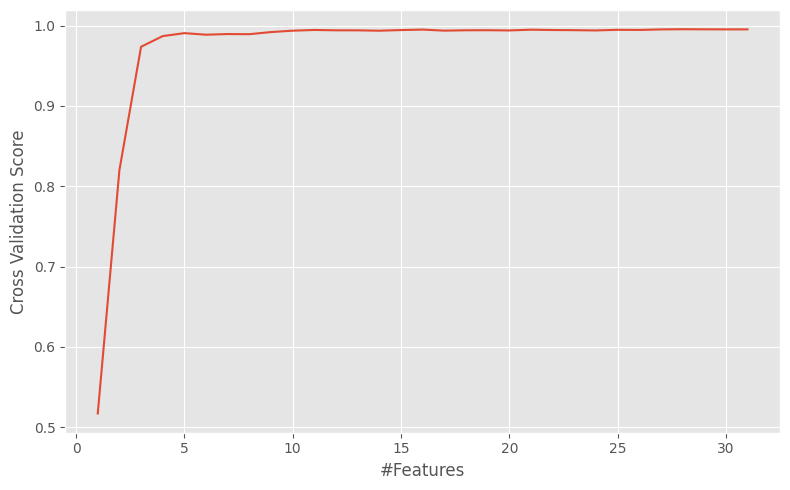

In [12]:
plt.figure(figsize=(8, 5))
plt.xlabel("#Features")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, 32), rfecv.cv_results_["mean_test_score"])
plt.tight_layout()
plt.show()